# Global Fishing Effort

In [91]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
# from scipy import stats
import matplotlib.dates as mdates

In [92]:
import argparse
import googleapiclient
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.client import GoogleCredentials
credentials = GoogleCredentials.get_application_default()
# Construct the service object for interacting with the BigQuery API.
bigquery_service = build('bigquery', 'v2', credentials=credentials)

In [93]:
# create a bounding box:
max_lat = 90
min_lat = -90
max_lon = 180
min_lon = -180
cellsize = .5

In [94]:
def Query(q):
    query_request = bigquery_service.jobs()
    query_data = {
        'query': (q)
    }
    query_response = query_request.query(
            projectId='world-fishing-827',
            body=query_data).execute()
    rows = []
    for row in query_response['rows']:
        s = [item['v'] for item in row['f']]
        rows.append(s)
    return rows

In [6]:
q = '''
select count(distinct mmsi) 
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5'''

number_of_mmsi = Query(q)

In [7]:
print "Number of unique MMSI:",number_of_mmsi[0][0]#int(number_of_mmsi[0]['f'][0]['v'])

Number of unique MMSI: 66245


# 66,245 MMSI were fishing between January 2014 to July 2015

# Map the Fishing Effort in This Region

In [95]:
# Now Group by lat, lon
q = '''
SELECT
lat,
lon,
count(*) fishing_days,
avg(distance_to_shore) distance_to_shore,
first(eez) eez
from
(SELECT
  mmsi,
  date(timestamp) date,
  integer(first(latitude)*2) lat,
  integer(first(longitude)*2) lon,
  first(FLOAT(JSON_EXTRACT(extra,"$.distance_to_shore"))) distance_to_shore,
  first(JSON_EXTRACT(extra,"$.eez")) EEZ,  
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > -90
  AND latitude <90
  AND longitude > -180
  AND longitude < 180
  AND weight >=.5
  and mmsi != 220364000 //this one is bad
  and mmsi not in(412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
  900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
  412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093) // these 
  // are mmsi that were spoofing according to Bjorn
  and JSON_EXTRACT(extra,"$.distance_to_shore") is not Null
group by mmsi, date) 
group by lat, lon
'''

fishing_grid = Query(q)

In [119]:
cellsize = .5
one_over_cellsize = 2

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = int(row[2])

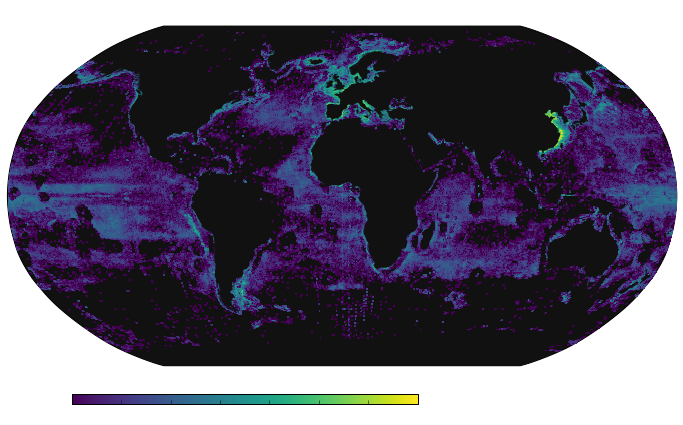

In [120]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = 100000
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Days, January 2014 to July 2015"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Number of Fishing Days, January 2014 to July 2015',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_days_2014-2015.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [121]:
grid = np.array(grid)

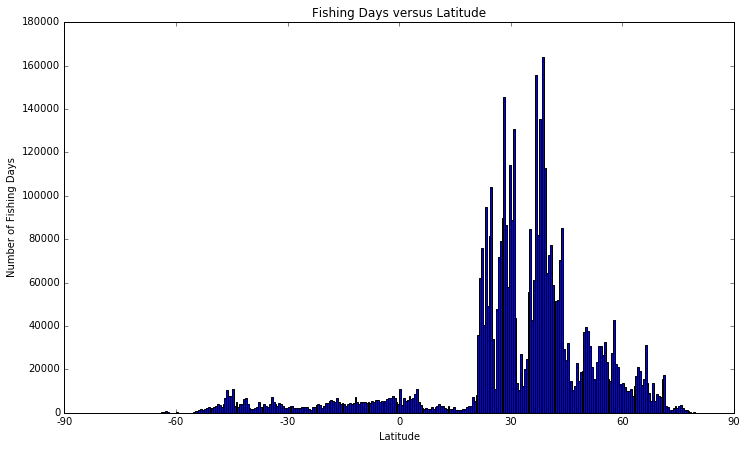

In [122]:
avg_by_lat = np.sum(grid, axis=1)
lat = [(i-180)/2. for i in range(180*2)]

ind = np.arange(len(lat))  # the x locations for the groups
width = 1      # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, avg_by_lat, width, color='b')
ax.set_ylabel('Number of Fishing Days')
ax.set_xlabel('Latitude')
ax.set_title('Fishing Days versus Latitude')
plt.xticks(np.arange(0,360*2,30*2))
ax.set_xticklabels((-90,-60,-30,0,30,60,90))
plt.xlim([0,360])
plt.show()



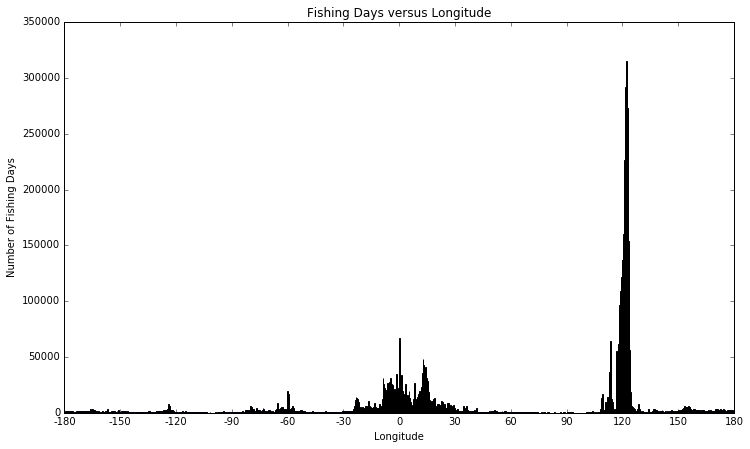

In [123]:
avg_by_lon = np.sum(grid, axis=0)
lon = [(i-360)/2. for i in range(360*2)]

ind = np.arange(len(lon))  # the x locations for the groups
width = 1      # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, avg_by_lon, width, color='b')
ax.set_ylabel('Number of Fishing Days')
ax.set_xlabel('Longitude')
ax.set_title('Fishing Days versus Longitude')
plt.xticks(np.arange(0,360*2+1,30*2))
ax.set_xticklabels((i for i in range(-180, 181, 30)))
plt.xlim([0,720])
plt.show()

In [124]:
fishings = []
distance_to_shore = []
for r in fishing_grid:
    fishings.append(int(r[2]))
    distance_to_shore.append(float(r[3]))
distance_to_shore = np.array(distance_to_shore)
fishings = np.array(fishings)

In [125]:
distance_to_shore.max()

2341.8555615550754

In [126]:
distances = np.zeros(int(distance_to_shore.max()/50)+1)
for d,f in zip(distance_to_shore,fishings):
    distances[int(d/50)] += f

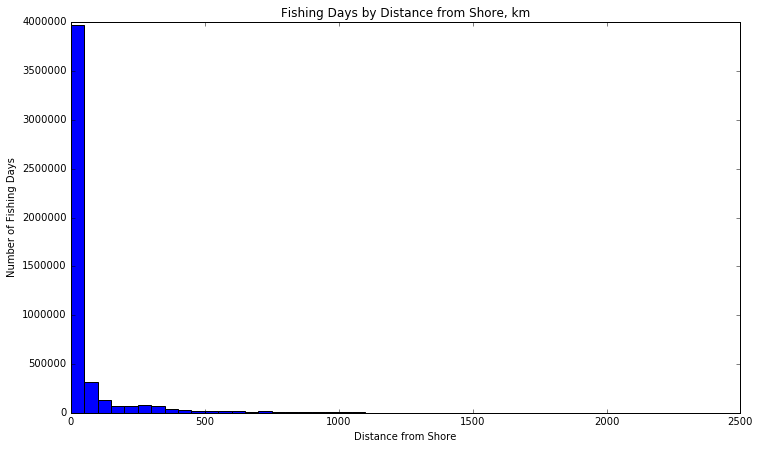

In [144]:
ind = np.arange(len(distances))  # the x locations for the groups
width = 1      # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, distances, width, color='b')
ax.set_ylabel('Number of Fishing Days')
ax.set_xlabel('Distance from Shore')
ax.set_title('Fishing Days by Distance from Shore, km')
plt.xticks(np.arange(0,51,10))
ax.set_xticklabels((i*50 for i in range(0,51,10)))
plt.show()

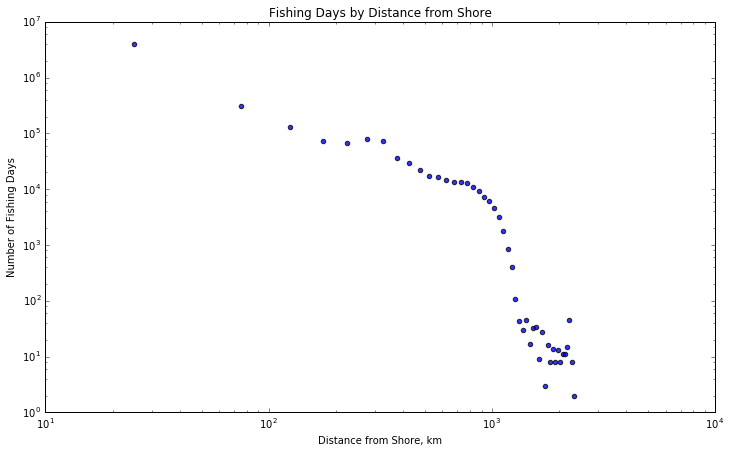

In [143]:
#log log!
x = [i*50+25 for i in range(len(distances))]
y = distances
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.set_xscale('log')
plt.scatter(x, y, alpha=.8)#, color = color)
plt.title("Fishing Days by Distance from Shore")
plt.xlabel('Distance from Shore, km')
plt.ylabel('Number of Fishing Days')
plt.show()

# Fishing effort in the High Seas versus EEZs

In [114]:
in_eezs=0
high_seas=0
for r in fishing_grid:
    if r[4]:
        in_eezs+=int(r[2])
    else:
        high_seas+=int(r[2])

In [116]:
print int(100*high_seas/float(in_eezs+high_seas)), "percent of fishing days are in the high seas"

5 percent of fishing days are in the high seas


# Only 5 percent of the fishing days are in the high seas!

# Okay, now make histogram of lat and lon for high seas only

In [139]:
cellsize = .5
one_over_cellsize = 2

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize
grid_highseas = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    if not row[4]:
        lat_index = lat-min_lat*one_over_cellsize
        lon_index = lon-min_lon*one_over_cellsize
        grid_highseas[lat_index][lon_index] = int(row[2])

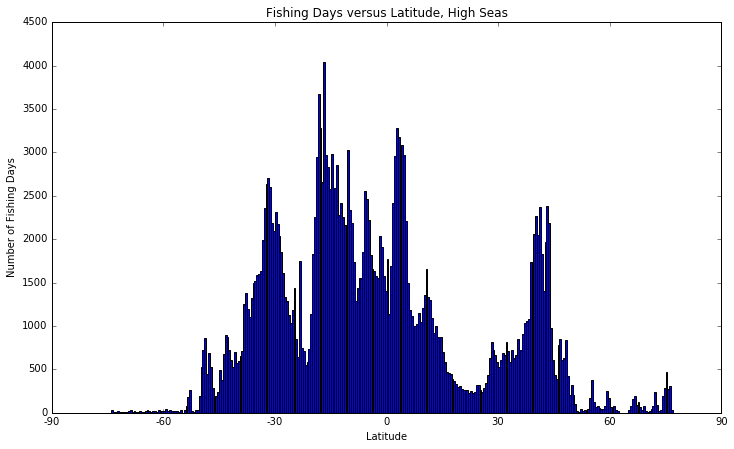

In [142]:
avg_by_lat = np.sum(grid_highseas, axis=1)
lat = [(i-180)/2. for i in range(180*2)]

ind = np.arange(len(lat))  # the x locations for the groups
width = 1      # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, avg_by_lat, width, color='b')
ax.set_ylabel('Number of Fishing Days')
ax.set_xlabel('Latitude')
ax.set_title('Fishing Days versus Latitude, High Seas')
plt.xticks(np.arange(0,360*2,30*2))
ax.set_xticklabels((-90,-60,-30,0,30,60,90))
plt.xlim([0,360])
plt.show()


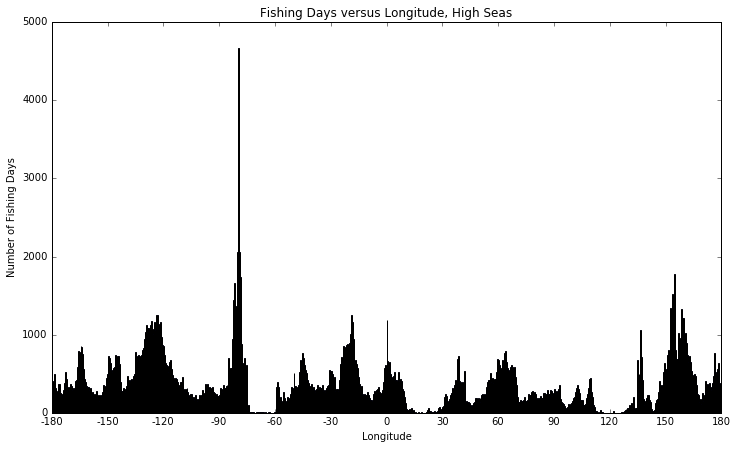

In [141]:
avg_by_lon = np.sum(grid_highseas, axis=0)
lon = [(i-360)/2. for i in range(360*2)]
ind = np.arange(len(lon))  # the x locations for the groups
width = 1      # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, avg_by_lon, width, color='b')
ax.set_ylabel('Number of Fishing Days')
ax.set_xlabel('Longitude')
ax.set_title('Fishing Days versus Longitude, High Seas')
plt.xticks(np.arange(0,360*2+1,30*2))
ax.set_xticklabels((i for i in range(-180, 181, 30)))
plt.xlim([0,720])
plt.show()